# [Kaggle][Cifar-10] Deep CNN

It gets to 75% validation accuracy in 25 epochs, and 79% after 50 epochs.

## 1. 關於 Cifar-10 資料集

CIFAR-10 資料集含有 60,000 張 32x32 彩色圖片，分為 10 類，每一類有 6000 張圖片。官方原始資料集的其中 50,000 張用來訓練，10,000 張用來測試。我們有保留原始資料集的訓練/測試分割。我們提供的檔案有：

- train.7z - png 檔案格式的訓練圖片
- test.7z - png 檔案格式的測試圖片
- trainLabels.csv - 訓練圖片的標籤
- sampleSubmission.csv - 提交答案的範例 (id, label)

為了勸阻某些作弊的形式 (例如手動加標籤)，我們在測試圖片集另外添加了 290,000 張垃圾圖片。這些圖片在評分時會被忽略。我們也在官方的 10,000 張測試圖片上，進行了無關緊要的改圖，以防止有人會使用檔案雜湊值來做查找。這些圖片異動應該不會太過影響分數。你應該要對全部 300,000 張測試圖片給出預測標籤。

資料集的圖片分作下列 10 個類別：

- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

類別完全沒有重疊。汽車 (automobiles) 和卡車 (trucks) 沒有重疊。汽車 (Automobile) 包含sedans, SUVs, 以及類似的車輛。卡車 (Truck) 只包含大卡車。兩者都不包含小卡車。

## 2. Import Library

In [1]:
import tensorflow as tf

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.models import Model
from keras.layers.core import Lambda
from keras.callbacks import EarlyStopping, LearningRateScheduler

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import os
from PIL import Image

C:\Users\neillee\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 3. 資料準備

先使用 Keras 提供的資料集做訓練和驗證，然後再將模型套用到 Kaggle 的測試圖片上

In [2]:
(X_train, y_train), (X_val, y_val) = cifar10.load_data()

## 4.1 訓練與驗證資料的預處理

In [3]:
print('train data:', 'images:', X_train.shape, " labels:", y_train.shape)
print('val data:', 'images:', X_val.shape, ' labels:', y_val.shape)

train data: images: (50000, 32, 32, 3)  labels: (50000, 1)
val data: images: (10000, 32, 32, 3)  labels: (10000, 1)


In [4]:
# Normalize
X_train = X_train.astype('float32') / 255.0
X_val   = X_val.astype('float32') / 255.0

In [5]:
# Map to convert between textual labels and numerical classes.
label_to_class = { 'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9 }
class_to_label = [ 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck' ]

In [6]:
# One hot encoding
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)

### 4.2 測試資料的預處理

In [7]:
test_dir = 'input/test'
test_ids = list(range(1, 300001))

In [8]:
X_test = np.array([np.array(Image.open(test_dir + '/' + str(test_id) + '.png' )) for test_id in test_ids])

In [9]:
X_test = X_test.astype('float32') / 255.0

## 4. Build model

In [10]:
# Training parameters
batch_size = 32
num_classes = 10
epochs = 1600
init_lr = 0.0001
weight_decay = 1e-4

data_augmentation = True

rows, cols = 32, 32
channels = 3

In [11]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(48, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(48, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(80, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(80, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(80, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(80, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(80, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.25))

model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [12]:
opt = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_3 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 48)        13872     
__________

In [14]:
from lsuv_init import LSUVinit

model = LSUVinit(model, X_train[:batch_size, :, :, :])

conv2d_1
LSUV initializing conv2d_1
0.03001838
0.99999994
activation_1
conv2d_2
LSUV initializing conv2d_2
0.07256476
0.9999995
activation_2
conv2d_3
LSUV initializing conv2d_3
0.027920663
1.0000001
activation_3
conv2d_4
LSUV initializing conv2d_4
0.04454322
0.9999998
activation_4
conv2d_5
LSUV initializing conv2d_5
0.03684223
1.0
activation_5
max_pooling2d_1
dropout_1
conv2d_6
LSUV initializing conv2d_6
0.024935763
1.0000005
activation_6
conv2d_7
LSUV initializing conv2d_7
0.014045073
0.9999999
activation_7
conv2d_8
LSUV initializing conv2d_8
0.021709315
0.9999999
activation_8
conv2d_9
LSUV initializing conv2d_9
0.011768572
1.0
activation_9
conv2d_10
LSUV initializing conv2d_10
0.02417082
1.0000002
activation_10
max_pooling2d_2
dropout_2
conv2d_11
LSUV initializing conv2d_11
0.012675786
1.0
activation_11
conv2d_12
LSUV initializing conv2d_12
0.00843372
0.9999999
activation_12
conv2d_13
LSUV initializing conv2d_13
0.008772284
1.0
activation_13
conv2d_14
LSUV initializing conv2d_14
0.01

## 5. Data augmentation

In [15]:
if not data_augmentation:
    print('Not using data augmentation.')
else:
    print('Using real-time data augmentation.')
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False) 

    datagen.fit(X_train)

Using real-time data augmentation.


## 6. Train

In [16]:
def lr_schedule(epoch):
    lr = init_lr
    if epoch > 75:
        lr = 0.00005
    elif epoch > 100:
        lr = 0.00003
    return lr

callbacks = [
    LearningRateScheduler(lr_schedule),
    EarlyStopping(monitor='val_acc', patience=10)
]

In [17]:
if not data_augmentation:
    history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_val, y_val),
          shuffle=True)
else:
    history = model.fit_generator(datagen.flow(X_train, y_train,
                                               batch_size=batch_size),
                                  epochs=epochs, 
                                  validation_data=(X_val, y_val), 
                                  workers=4,
                                  verbose=1,
                                  callbacks=callbacks)

Epoch 1/1600
1563/1563 [==============================] - 352s 225ms/step - loss: 2.0936 - acc: 0.1972 - val_loss: 1.7197 - val_acc: 0.3597
Epoch 2/1600
1563/1563 [==============================] - 346s 221ms/step - loss: 1.6850 - acc: 0.3685 - val_loss: 1.4694 - val_acc: 0.4479
Epoch 3/1600
1563/1563 [==============================] - 351s 225ms/step - loss: 1.4983 - acc: 0.4458 - val_loss: 1.3946 - val_acc: 0.5019
Epoch 4/1600
1563/1563 [==============================] - 363s 232ms/step - loss: 1.3599 - acc: 0.5065 - val_loss: 1.3309 - val_acc: 0.5261
Epoch 5/1600
1563/1563 [==============================] - 368s 236ms/step - loss: 1.2585 - acc: 0.5490 - val_loss: 1.1428 - val_acc: 0.5897
Epoch 6/1600
1563/1563 [==============================] - 366s 234ms/step - loss: 1.1828 - acc: 0.5748 - val_loss: 1.2241 - val_acc: 0.5725
Epoch 7/1600
1563/1563 [==============================] - 364s 233ms/step - loss: 1.1100 - acc: 0.6060 - val_loss: 1.0242 - val_acc: 0.6369
Epoch 8/1600
1563/15

In [18]:
# Score trained model.
scores = model.evaluate(X_val, y_val, verbose=1)
print('Val loss:', scores[0])
print('Val accuracy:', scores[1])

10000/10000 [==============================] - 21s 2ms/step
Val loss: 0.43456565600633623
Val accuracy: 0.8712


In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_train_history(train_history, y_label = 'Accuracy', train_metric = 'acc', val_metric = 'val_acc'):
    # plot training history
    plt.plot(history.history[train_metric])
    plt.plot(history.history[val_metric])
    plt.title('Training history')
    plt.ylabel(y_label)
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

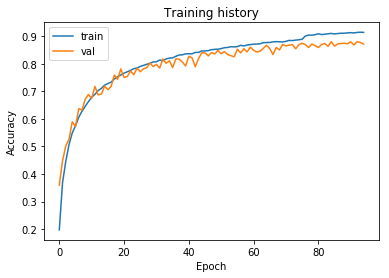

In [20]:
show_train_history(history)

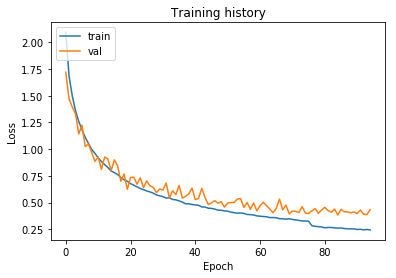

In [21]:
show_train_history(history, y_label = 'Loss', train_metric = 'loss', val_metric = 'val_loss')

## 7. Save Weight to h5

In [22]:
score = model.evaluate(X_val, y_val, verbose=0)[1]
score

0.8712

In [23]:
filename = 'SavedModel/cifar10-cnn-deep-{}.h5'.format(score)
model.save_weights(filename)
print('Saved model weights to ' + filename)

Saved model weights to SavedModel/cifar10-cnn-deep-0.8712.h5


## 8. Predict

In [24]:
prediction = model.predict_classes(X_test)

In [25]:
labels = [ class_to_label[prediction[i]] for i in range(len(prediction))]

# 9. Submit

In [26]:
df_submission = pd.DataFrame(data = { 'id': test_ids, 'label': labels }, columns = [ 'id', 'label' ])

In [27]:
df_submission.to_csv('output/submission-{}.csv'.format(score), index=False)